
Welcome to this tutorial on installing and using the latest CorgiSim simulation tools. In this guide, we'll walk through how to set up and run simulations of an on-axis host star with off-axis companions for observations with the Roman Coronagraph Instrument (CGI).

 This tutorial is intended to help you get started quickly and to provide a clear overview of CorgiSim’s current infrastructure and workflow. It's especially geared toward those interested in contributing to the development and improvement of the code.


# Installation

Since **CorgiSim** is still under active development, we recommend cloning the **main** branch from the repository and installing it in **editable mode**. It's also best to work in a **virtual environment** to avoid conflicts with other packages.

## Step-by-step instructions

1. **Clone the repository:**


```
    git clone -b main https://github.com/roman-corgi/corgisim.git
    cd corgisim
```
2. **Install in editable mode:**

```
    pip install -e .
```

## Required dependencies
To install the required dependencies, run:
```
    pip install -r requirements.txt
```
This will install all Python packages available via `pip`, including `synphot`.  
For more information on `synphot`, refer to its [documentation](https://synphot.readthedocs.io/en/latest/#installation-and-setup).

> ⚠️ Note: Some packages must be installed manually because they are not available on PyPI:

- **cgisim**: [https://sourceforge.net/projects/cgisim/](https://sourceforge.net/projects/cgisim/)
- **roman_preflight**: [https://sourceforge.net/projects/cgisim/files/](https://sourceforge.net/projects/cgisim/files/)
- **PROPER**: [https://sourceforge.net/projects/proper-library/](https://sourceforge.net/projects/proper-library/)

Detailed installation instructions for the required dependencies can be found in the README of Corgisim github repo: https://github.com/roman-corgi/corgisim/tree/main?tab=readme-ov-file



# Run the first simulation


In [1]:
## import packages
from corgisim import scene
from corgisim import instrument
import matplotlib.pyplot as plt
import numpy as np
import proper
from corgisim import outputs
from astropy.io import fits

# import astropy.units as u

#### Step 0: Copying a Prescription File

To get started, you'll need a Roman CGI prescription file in your working folder. The `roman_preflight_proper` package provides a helper function to copy a default prescription file into your current working directory.         

Note: If the file is already present, you can skip this step. However, you'll need to repeat it whenever you switch to a new working directory.



In [2]:
#First, import the module:
import roman_preflight_proper
### Then, run the following command to copy the default prescription file 
roman_preflight_proper.copy_here()

### Step 1: Define the Astrophysical Scene

Begin by specifying the astrophysical scene you want to simulate. This typically includes:

- A **host star**
- One or more **companions** (e.g., exoplanets or brown dwarfs)
- *(Future feature)* A 2D background scene, such as circumstellar disks — *not yet implemented*

> **Note:** As of now, only point sources (host stars and companions) are supported. 2D scene functionality will be added in future versions.

#### 🔹 Host Star

The following parameters are required for defining the host star:

1. **Spectral type** (e.g., `"G2V"`)
2. **V-band magnitude** (numeric value)
3. **Magnitude type** — currently, only **Vega magnitude** (`"vegamag"`) is supported

#### 🔹 Companions

You may define multiple companions. For each one, specify:

1. **V-band magnitude** brigtness of the companions  
2. **Magnitude type** — currently, only **Vega magnitude** (`"vegamag"`) is supported  
3. **position_x** — X-coordinate of the source position in milliarcseconds (mas), relative to the host star  
4. **position_y** — Y-coordinate of the source position in milliarcseconds (mas), relative to the host star  
For companion spectrum, currently, a flat spectrum will be generated based on the V-band magnitude

✅ Make sure to provide values in the expected format so the simulation can interpret the astrophysical inputs correctly.


In [3]:
# --- Host Star Properties ---
Vmag = 8                            # V-band magnitude of the host star
sptype = 'G0V'                      # Spectral type of the host star
ref_flag = False                    # if the target is a reference star or not, default is False
host_star_properties = {'Vmag': Vmag,
                        'spectral_type': sptype,
                        'magtype': 'vegamag',
                        'ref_flag': False}
mag_disk = 5.774+7.37           # List of magnitudes for each companion
# --- Companion Properties ---
# Define two companions
mag_companion = [25, 25]           # List of magnitudes for each companion

# Define their positions relative to the host star, in milliarcseconds (mas)
# For reference: 1 λ/D at 550 nm with a 2.3 m telescope is ~49.3 mas
# We're placing them at a separation of 3 λ/D
dx = [3 * 49.3, -3 * 49.3]         # X positions in mas for each companion
dy = [3 * 49.3, -3 * 49.3]         # Y positions in mas for each companion

# Construct a list of dictionaries for all companion point sources
point_source_info = [
    {
        'Vmag': mag_companion[0],
        'magtype': 'vegamag',
        'position_x': dx[0],
        'position_y': dy[0]
    },
    {
        'Vmag': mag_companion[1],
        'magtype': 'vegamag',
        'position_x': dx[1],
        'position_y': dy[1]
    }
]

twoD_scene_hdu = {
        # 'Vmag': mag_disk,
        # 'magtype': 'vegamag',
        # 'position_x': dx[0],
        # 'position_y': dy[0]
    }

# --- 2D scene properties ---
fpath = '/Users/sxie/repos/eps_eri_su_34_2.fits'
obj_hdu = fits.open(fpath)[0]  # Open the FITS file and get the first HDU
# obj = obj_hdu.data

# --- Create the Astrophysical Scene ---
# This Scene object combines the host star and companion(s)
base_scene = scene.Scene(host_star_properties, point_source_info, obj_hdu)
# base_scene = scene.Scene(host_star_properties, point_source_info,  twoD_scene_hdu)

# --- Access the generated stellar spectrum ---
sp_star = base_scene.stellar_spectrum
# --- Access the generated companion spectrum ---
sp_comp = base_scene.off_axis_source_spectrum 


Adding 2 off-axis sources


The output of ```base_scene.stellar_spectrum``` is a ```SourceSpectrum``` object from ```synphot``` package. Details see https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SourceSpectrum.html#synphot.spectrum.SourceSpectrum

The output of ```base_scene.off_axis_source_spectrum```  is a list of ```SourceSpectrum``` object,  each corresponding to an input companion.

The default unit for wavelength is **Angstrom**, and the default unit for flux density is **photlam** (photons/s/cm^2/Angstrom). For units in ```synphot``` see: https://synphot.readthedocs.io/en/latest/synphot/units.html#synphot-flux-units

Let's plot the stellar spectrum to have a look. Currently, we only have blackbody spectrum, but will add more complated ones in future.


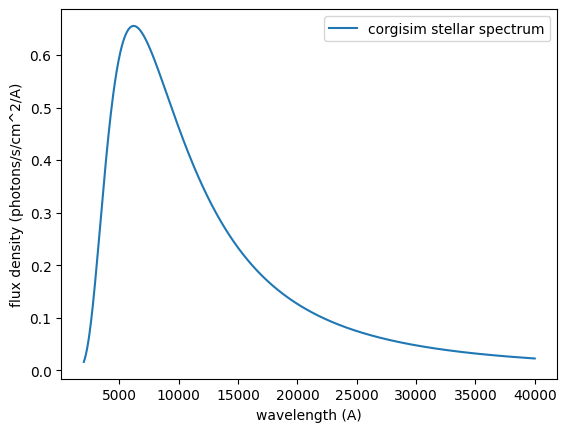

In [4]:
ax=plt.subplot(111)
#sp.plot(ax=ax)
lambd = np.linspace(2000, 40000, 1000)
ax.plot(lambd , sp_star(lambd  ).value,label='corgisim stellar spectrum')
ax.set_xlabel('wavelength (A)')
ax.set_ylabel('flux density (photons/s/cm^2/A)')
plt.legend()

Let's then plot the spectrum of the first companion. Since we didn't provide a custom spectrum, it uses the default flat spectrum automatically generated based on its V-band magnitude.

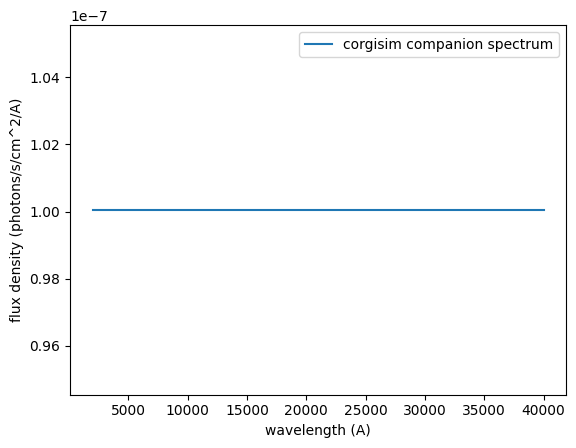

In [5]:
ax=plt.subplot(111)
#sp.plot(ax=ax)
lambd = np.linspace(2000, 40000, 1000)
ax.plot(lambd , sp_comp[0](lambd  ).value,label='corgisim companion spectrum')
ax.set_xlabel('wavelength (A)')
ax.set_ylabel('flux density (photons/s/cm^2/A)')
plt.legend()

#### Step 2: now you need to define the parameters for the telescope and instrument

The simulation mode is inherited from cgisim. In general, there are three supported modes, though currently only excam is implemented.

In [6]:
# Simulation mode (currently only 'excam' is implemented)
# Options include:
#   - 'excam': direct imaging mode (returns intensity image)
#   - 'spec': spectral mode using the "spc-spec" coronagraph
#   - 'excam_efield': like 'excam', but returns electric field across wavelengths instead of intensity
cgi_mode = 'excam'


Choose the coronagraph type to use in the simulation. As of now, only hlc is implemented.

In [7]:
# Coronagraph type
# Options (availability depends on implementation status):
#   - 'hlc', 'hlc_band1', 'hlc_band2', 'hlc_band3', 'hlc_band4'
#   - 'spc-spec_band2', 'spc-spec_band3'
#   - 'spc-wide_band1', 'spc-wide_band4'
#   - 'spc-mswc_band1', 'spc-mswc_band4'

cor_type = 'hlc'


Set bandpass filter to use with the selected coronagraph. The available options depend on the chosen **cor_type**.  
For example, if using `'hlc'` or `'hlc_band1'`, valid bandpasses include: `'1'`, `'1a'`, `'1b'`, `'1c'`, `'1_all'`.  
Refer to the table below for the valid bandpasses corresponding to each **cor_type**, as well as the definitions of the bandpasses. For more details on available bandpasses and how they’re defined, see the cgisim documentation: **cgisim_public_v4.0.pdf** You can donwload the cgisim_v4.0.zip from https://sourceforge.net/projects/cgisim/files/. The ZIP archive includes the documentation file.


| **cor_type**                                               | **Allowed Bandpasses**                                  |
|------------------------------------------------------------|----------------------------------------------------------|
| hlc or hlc_band1                                           | 1F, 1A, 1B, 1C, 1_ALL                                    |
| hlc_band2                                                  | 2F, 2A, 2B, 2C, 3A, 3B                                   |
| hlc_band3                                                  | 3F, 3A, 3B, 3C, 3D, 3E, 3G                               |
| hlc_band4                                                  | 4F, 4A, 4B, 4C                                           |
| spc-spec_band2                                             | 2F, 2A, 2B, 2C, 3A, 3B                                   |
| spc-spec_band2_rotated                                     | 2F, 2A, 2B, 2C, 3A, 3B                                   |
| spc-spec or spc-spec_band3                                 | 3F, 3A, 3B, 3C, 3D, 3E, 3G                               |
| spc-wide_band1                                             | 1F, 1A, 1B, 1C                                           |
| spc-wide or spc-wide_band4                                 | 4F, 4A, 4B, 4C                                           |
| spc-mswc_band1                                             | 1F, 1A, 1B, 1C                                           |
| spc-mswc or spc-mswc_band4                                 | 4F, 4A, 4B, 4C                                           |

| Bandpass Name | Central Wavelength λ<sub>c</sub> | FWHM Bandwidth Δλ/λ<sub>c</sub> |
|---------------|-------------------------------|------------------------------|
| 1F             | 575 nm                        | 10.1 %                       |
| 1A            | 556 nm                        | 3.5 %                        |
| 1B            | 575 nm                        | 3.3 %                        |
| 1C            | 594 nm                        | 3.2 %                        |
| 2F             | 660 nm                        | 17.0 %                       |
| 2A            | 615 nm                        | 3.6 %                        |
| 2B            | 638 nm                        | 2.8 %                        |
| 2C            | 656 nm                        | 1.0 %                        |
| 3F             | 730 nm                        | 16.7 %                       |
| 3A            | 681 nm                        | 3.5 %                        |
| 3B            | 704 nm                        | 3.4 %                        |
| 3C            | 727 nm                        | 2.8 %                        |
| 3G            | 752 nm                        | 3.4 %                        |
| 3D            | 754 nm                        | 1.0 %                        |
| 3E            | 778 nm                        | 3.5 %                        |
| 4F             | 825 nm                        | 11.4 %                       |
| 4A            | 792 nm                        | 3.5 %                        |
| 4B            | 825 nm                        | 3.6 %                        |
| 4C            | 857 nm                        | 3.5 %                        |


In [8]:
bandpass = '1F'

Load a Pre-Saved DM File. Several pre-generated deformable mirror (DM) files are available for different coronagraph types and contrast configurations. The DM solution files are stored in the  ```examples ``` folder of  ```roman_preflight_proper ```

Available configurations:
- HLC:
    hlc_ni_2e-9, hlc_ni_3e-8, hlc_ni_5e-9

- SPC-Spec:
    spc-spec_ni_1e-9, spc-spec_ni_2e-8, spc-spec_ni_4e-9

- SPC-Wide:
    spc-wide_ni_2e-8, spc-wide_ni_3e-9, spc-wide_ni_5e-9

In [9]:
cases = ['3e-8']       
rootname = 'hlc_ni_' + cases[0]
dm1 = proper.prop_fits_read( roman_preflight_proper.lib_dir + '/examples/'+rootname+'_dm1_v.fits' )
dm2 = proper.prop_fits_read( roman_preflight_proper.lib_dir + '/examples/'+rootname+'_dm2_v.fits' )


In [10]:
##  Define the polaxis parameter. Use 10 for non-polaxis cases only, as other options are not yet implemented.
polaxis = 10
# output_dim define the size of the output image
output_dim = 51

### define a dictinatary to pass keywarod to proper
### proper_keywords are the keyword arguments to the internal functions for package proper, which define the optics of coronagraph
# use_dm1/use_dm2: if use dm
# use_fpm: if use focal plane mask
# use_lyot_stop: if use lyot stop 
# use_field_stop: if use field stop
# other paramters that could pass to Proper defined by CgiSim

proper_keywords ={'cor_type':cor_type, 'use_errors':2, 'polaxis':polaxis, 'output_dim':output_dim,\
                    'use_dm1':1, 'dm1_v':dm1, 'use_dm2':1, 'dm2_v':dm2,'use_fpm':1, 'use_lyot_stop':1,  'use_field_stop':1 }

##define the corgi.optics class that hold all information about the instrument paramters                    
optics = instrument.CorgiOptics(cgi_mode, bandpass, proper_keywords=proper_keywords, if_quiet=True)

CorgiOptics initialized with proper keywords.


In [11]:
proper_keywords

{'cor_type': 'hlc',
 'use_errors': 2,
 'polaxis': 10,
 'output_dim': 51,
 'use_dm1': 1,
 'dm1_v': array([[39.77722339, 39.77722339, 39.77722339, ..., 39.83926947,
         39.83926947, 39.83926947],
        [39.77722339, 39.77722339, 39.77722339, ..., 39.83926947,
         39.83926947, 39.83926947],
        [39.77722339, 39.77722339, 39.77722339, ..., 39.83926947,
         39.83926947, 39.83926947],
        ...,
        [40.00199709, 40.00199709, 40.00199709, ..., 39.87353396,
         39.87353396, 39.87353396],
        [40.00199709, 40.00199709, 40.00199709, ..., 39.87353396,
         39.87353396, 39.87353396],
        [40.00199709, 40.00199709, 40.00199709, ..., 39.87353396,
         39.87353396, 39.87353396]]),
 'use_dm2': 1,
 'dm2_v': array([[39.7406075 , 39.7406075 , 39.7406075 , ..., 39.59029346,
         39.59029346, 39.59029346],
        [39.7406075 , 39.7406075 , 39.7406075 , ..., 39.59029346,
         39.59029346, 39.59029346],
        [39.7406075 , 39.7406075 , 39.7406075 , 

Now let's plot the filter curve. 
Note that you don’t need to set up the bandpass manually when running CorgiSim — ```corgisim.optics``` will automatically select the appropriate bandpass based on the input filter number. The following is for illustration purposes only.

the output of ```optics.setup_bandpass``` is ```SpectralElement``` object from ```synphot```, details see https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SpectralElement.html#synphot.spectrum.SpectralElement

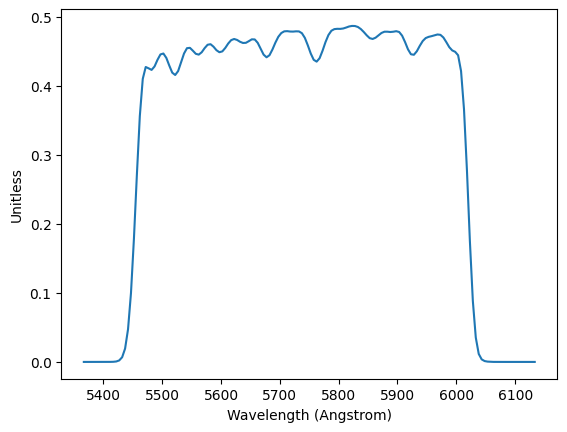

In [12]:
nd_filter = 0
# bp = optics.setup_bandpass(cgi_mode, bandpass, nd_filter )
optics.bp.plot()

TODO - Here is testing the bandpass width and how to implement this in to the code. 

In [13]:
dlam_um = optics.lam_um[1] - optics.lam_um[0]
print(dlam_um, optics.lam_um)

# lam_start_um = np.min(self.lam_um)-  1* dlam_um
# lam_end_um = np.max(self.lam_um)+  1* dlam_um
# bandpass_i = 'lam' + str(lam_start_um*1000) + 'lam' + str(lam_end_um*1000) 

0.009583333333333388 [0.54625    0.55583333 0.56541667 0.575      0.58458333 0.59416667
 0.60375   ]


### 💡 Tip for Delevoper

If you want to integrate the stellar flux over a given bandpass, you can use the `Observation` class from `synphot`. This allows you to compute the photon count rate through a filter while accounting for the filter transmission curve. Below is an example of how to calculate the integrated photon counts for the stellar spectrum after applying a defined bandpass **bp** from the previous steps.


> ⚠️ You **do not** need to do this step manually for running corgisim.  
> This example is only meant to demonstrate how `corgisim` performs bandpass integration internally.



In [14]:
from synphot import  Observation
# Compute the observed stellar spectrum within the defined bandpass
# obs: wavelegth is in unit of angstrom
# obs: flux is in unit of photons/s/cm^2/angstrom
obs = Observation(base_scene.stellar_spectrum, optics.bp)
#obs.plot()

area = 35895.212    # primary effective area for Roman from cgisim in cm^2
# Compute total photon counts integrated across the full bandpass
counts = obs.countrate(area=area)
print('Total counts across the bandpass:',counts)
## you can also integrate across a narrower wavelength range within the bandpass
counts_sub = obs.countrate(area=area,  waverange=[5700, 5800])
print('Total counts from 5700-5800 A:',counts_sub)

Total counts across the bandpass: 6055798.844333797 ct / s
Total counts from 5700-5800 A: 1089517.136934274 ct / s


### Step 3: Generate the PSF for the on-axis star and inject companions

The `get_psf` function from the `CorgiOptics` class generates the on-axis PSF for the host star. It takes the following inputs:

- **input_scene**: A `corgisim.scene.Scene` object that defines the properties of the host star to be simulated.
- **sim_scene** *(optional)*: A `corgisim.SimulatedImage` object that stores the simulated scene.  
  If `None`, the function will generate a new `SimulatedImage` object as output.  
  If provided, the function will update the existing `sim_scene` with the simulated image of on-axis host star psf.

The output is an Astropy HDU containing the simulated image, with header comments detailing the input host star properties and simulation setup.

In [15]:
## Pass the base_scene object to corgi.optics and use get_psf to simulate the host star PSF.
## The result is stored in a SimulatedScene object as an Astropy HDU containing both data and header information.

sim_scene = optics.get_host_star_psf(base_scene)
image_star_corgi = sim_scene.host_star_image.data

#### Step 4: Calling 2D scene and performing 2D convolution 

At the moment, the object is loaded in `base_scene`. The `convolution.py` module contains helper functions to perform field-dependent convolutions, with the option for weighted interpolation. 

### Key Variables and Objects in Use

- **`base_scene`**: A `corgisim.scene.Scene` object that holds the astrophysical scene, including the host star and companions.
- **`convolution.py`**: Provides utilities for field-dependent PSF convolution and interpolation.
- **`test_prf`**: A pre-defined PSF cube used for convolution.
- **`radii_lamD_1`**: Radial grid for PSF computation in units of λ/D.
- **`azimuths_deg_1`**: Azimuthal grid for PSF computation in degrees.
- **`conv2d`**: The result of the 2D convolution applied to the scene.
- **`combined_image_corgi`**: The final combined image after convolution and integration of the host star and companions.
- **`optics`**: A `corgisim.instrument.CorgiOptics` object that holds the instrument parameters and performs PSF generation and convolution.

### Current Workflow

1. **Scene Definition**:
    - The astrophysical scene is defined in `base_scene`, including the host star and companions.

2. **PSF Convolution**:
    - The `convolution.py` module is used to perform field-dependent PSF convolution.
    - Pre-defined PSF cubes (`test_prf`) or dynamically generated PSF cubes can be used.

3. **2D Convolution**:
    - The `optics.convolve_2d_scene` function applies the convolution to the scene using the specified radial and azimuthal grids.

4. **Output**:
    - The convolved image (`conv2d`) is stored in `base_scene.background_scene` or `sim_scene.twoD_image`, depending on the input scene type.

### Notes

- Ensure that the radial and azimuthal grids (`radii_lamD_1`, `azimuths_deg_1`) are appropriately defined for the desired field-dependent PSF computation.
- The `optics` object automatically handles the instrument parameters, including the bandpass filter and deformable mirror settings.
- The `combined_image_corgi` variable holds the final processed image, which can be visualized or passed to subsequent steps. (Not implemented yet)

(-0.5, 50.5, 50.5, -0.5)

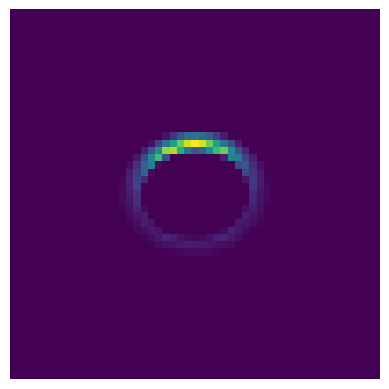

In [16]:
plt.imshow(base_scene._twoD_scene.data)
plt.axis('off')

#### Step 4.1: Build Sampling Grid for Field-Dependent PSF Computation

To perform field-dependent PSF computations, you need to define a sampling grid. This involves creating radial and azimuthal grids, which serve as the foundation for PSF sampling. Below is an example of how to use the `build_radial_grid` and `build_azimuth_grid` functions to construct these grids.

Offsets in the radial and azimuthal grids are essential for field-dependent PSF computations because the PSF (Point Spread Function) of an optical system can vary across the field of view. These variations arise due to:

1. **Field Dependence**:
    - Optical aberrations, such as coma and astigmatism, can cause the PSF to change depending on the position in the field.
    - The PSF at the center of the field (on-axis) is typically different from the PSF at the edges (off-axis).

2. **Sampling the Field**:
    - To accurately model and simulate the PSF across the field, we need to sample it at various positions. This is done by defining a grid of radial and azimuthal offsets.
    - The radial grid specifies distances from the optical axis (in units of λ/D), while the azimuthal grid specifies angular positions (in degrees).

3. **Interpolation**:
    - Once the PSF is computed or measured at these grid points, it can be interpolated to estimate the PSF at any arbitrary position within the field.
    - This ensures that the simulation accurately represents the spatially varying PSF.

4. **Convolution with the Scene**:
    - The offsets allow the PSF to be applied correctly to different parts of the astrophysical scene during convolution, ensuring that the final image accounts for field-dependent effects.

In summary, these offsets are critical for capturing the spatial variations in the PSF and ensuring that the simulated images are realistic and accurate. Without these offsets, the simulation would assume a uniform PSF across the field, which is not representative of real optical systems.

Below is an example of how to define the radial and azimuthal grids using the `build_radial_grid` and `build_azimuth_grid` functions:


In [17]:
from corgisim import convolution as conv
import time  
import sys
import corgisim.convolution as conv 

# radial: 0, 5, 10  λ/D   (3 nodes)
# azimuth: 0–270° in steps of 90° (4 nodes)

radii_lamD_1 = conv.build_radial_grid(
    inner_step      = 5,     # step inside IWA (λ/D)
    mid_step        = 5,     # step between IWA and OWA
    outer_step      = 5,     # step beyond OWA (λ/D)
    iwa             = 0,     # inner working angle (λ/D)
    owa             = 10,    # outer working angle (λ/D)
)

azimuths_deg_1 = conv.build_azimuth_grid(
    step_deg        = 90  # azimuthal step in degrees
)



### Creating a Small Cube for Faster Processing

To speed up the processing, we will create a smaller cube. This smaller cube will be used for testing and debugging purposes, ensuring quicker iterations while maintaining the core functionality.


In [18]:
test_prf = optics.make_prf_cube(
    radii_lamD_1,
    azimuths_deg_1)

[████████████████████████████████████████] 13/13 (100.0%)


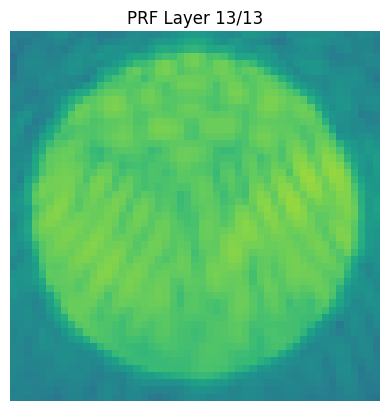

In [19]:
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis for the animation
fig, ax = plt.subplots()
im = ax.imshow(test_prf[0], cmap='viridis', norm=LogNorm(vmin=test_prf.min(), vmax=test_prf.max()))
ax.axis('off')
ax.set_title("PRF Changes Over Layers")

# Update function for the animation
def update(frame):
    im.set_data(test_prf[frame])
    ax.set_title(f"PRF Layer {frame + 1}/{test_prf.shape[0]}")
    return [im]

# Create the animation
ani = FuncAnimation(fig, update, frames=test_prf.shape[0], interval=200, blit=True)

# Display the animation in the notebook
HTML(ani.to_jshtml())

In the current implementation, there are two modes for performing convolution with the PSF:

#### **Mode 1: Using Precomputed PRF Cubes**
- Utilises precomputed PRF cubes stored .fits  
- matching radial/azimuthal grids --> information (e.g., `radii_lamD_1`, `azimuths_deg_1`) or at least we need to know the command generating it if using corgisim


#### **Mode 2: Generating PRF Cubes on the Fly**
- Dynamically generates PRF cubes, defines sampling points in the field of view (FoV).

#### Notes: Ensure grids match the PRF cube in **Mode 1**.


#### mode 2: Generate PRF cubes on the fly


In [20]:
optics.convolve_2d_scene(base_scene,iwa=0, owa=10, inner_step=5, mid_step=5, outer_step=5, step_deg=90)

[████████████████████████████████████████] 13/13 (100.0%)


TODO - Determine which scene and how it should be saved.  
Currently, after performing convolution, the input scene in `convolve_2d_scene` will be updated based on the type of scene object used:  
- If the input is a `SimulatedImage` object, then `scene.twoD_image = conv2d`.  
- If the input is a `Scene` object, then `scene.background_scene = conv2d`.  

Otherwise, an error will occur. Currently, no data is returned. Depending on the desired approach, we can either:  
1. Return the data and write a wrapper to define how the scene should be updated.  
2. Keep the current behavior, ensuring that an input scene is always provided.  

Note: The input scene is mandatory in the current implementation.


(-0.5, 50.5, 50.5, -0.5)

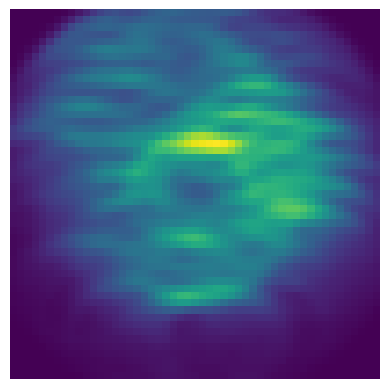

In [21]:
plt.imshow(base_scene.background_scene)
plt.axis('off')

#### mode 1: Use pre-define cube 

In [22]:
optics.convolve_2d_scene(base_scene, 
                              prf_cube=test_prf,
                              prf_grid_radii=radii_lamD_1, 
                              prf_grid_azimuths=azimuths_deg_1, use_bilinear_interpolation=True)

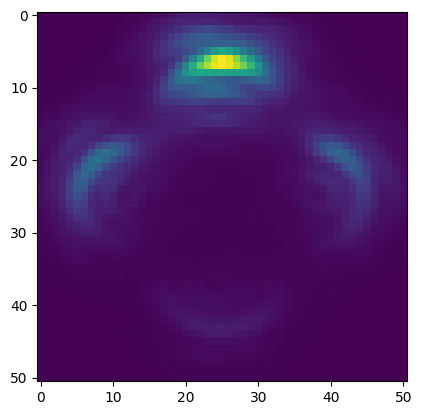

In [23]:
plt.imshow(base_scene.background_scene)

Here we have more sampling points for a detailed analysis.

In [24]:
fname = 'prfs_cube_detector.fits'# Your path to the fits file 
path = '/Users/sxie/repos/'# Your path to the fits file 
hdr = fits.open(path + fname)
corgi_prf_cubes = hdr[0].data

Below is the command used to generate the example prf_cube (do not change it, unless it's needed)

In [25]:
from corgisim import convolution as conv
import time  
import sys
import corgisim.convolution as conv 

radii_lamD = conv.build_radial_grid(
    inner_step      = 1,     # step inside IWA (λ/D)
    mid_step        = 1,     # step between IWA and OWA
    iwa             = 1,     # inner working angle (λ/D)
    owa             = 10,    # outer working angle (λ/D)
    outer_step = 1.
)

azimuths_deg = conv.build_azimuth_grid(step_deg= 10)

Now we simulate off-axis point sources and the disk, and inject them into the host star on-axis PSF image.

In [26]:
sim_scene = optics.get_host_star_psf(base_scene)
image_star_corgi = sim_scene.host_star_image.data


sim_scene = optics.inject_point_sources(base_scene,sim_scene)
image_comp_corgi = sim_scene.point_source_image.data 

sim_scene = optics.convolve_2d_scene(input_scene=base_scene, sim_scene = sim_scene, 
                              prf_cube=corgi_prf_cubes,
                              prf_grid_radii=radii_lamD, 
                              prf_grid_azimuths=azimuths_deg, use_bilinear_interpolation=True)


image_disk_corgi = sim_scene.twoD_image.data 
combined_image_corgi = image_star_corgi + image_disk_corgi + image_comp_corgi

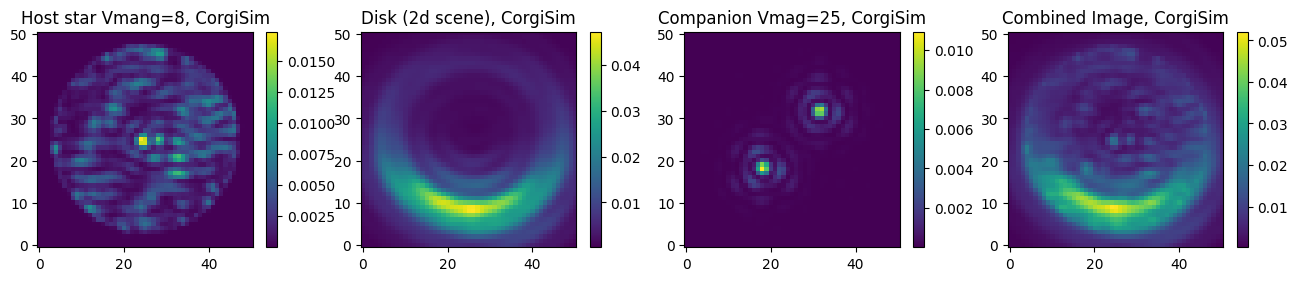

In [27]:
fig = plt.figure(figsize=(12+4,4))
plt.subplot(141)
plt.imshow(image_star_corgi,origin='lower')
plt.title('Host star Vmang=8, CorgiSim')

co = plt.colorbar(shrink=0.7)
plt.subplot(142)
plt.imshow(image_disk_corgi,origin='lower')
plt.title('Disk (2d scene), CorgiSim')
co = plt.colorbar(shrink=0.7)

plt.subplot(143)
plt.imshow(image_comp_corgi,origin='lower')
plt.title('Companion Vmag=25, CorgiSim')
co = plt.colorbar(shrink=0.7)

plt.subplot(144)
plt.imshow(combined_image_corgi,origin='lower')
plt.title('Combined Image, CorgiSim')

co = plt.colorbar(shrink=0.7)

If you only care about the result of the convolution, you can directly perform it using the following command (ensure you have the PRF cubes and grid ready):


In [28]:
# without bilinear interpolation
conv2d = conv.convolve_with_prfs(
            obj=base_scene._twoD_scene.data,
            prfs_array=corgi_prf_cubes,
            radii_lamD=radii_lamD,
            azimuths_deg=azimuths_deg,
            pix_scale_mas=21.8,
            res_mas=50, use_bilinear_interpolation=False
        )

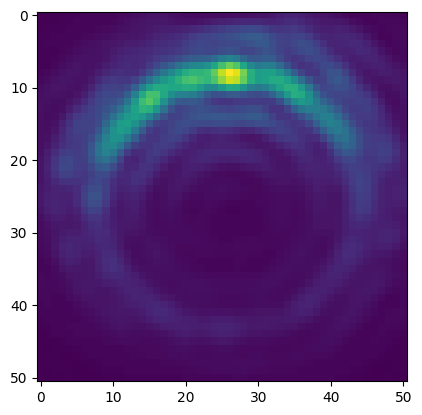

In [29]:
plt.imshow(conv2d)

In [30]:
# without bilinear interpolation
conv2d = conv.convolve_with_prfs(
            obj=base_scene._twoD_scene.data,
            prfs_array=corgi_prf_cubes,
            radii_lamD=radii_lamD,
            azimuths_deg=azimuths_deg,
            pix_scale_mas=21.8, # pixel scale in mas
            res_mas=50, use_bilinear_interpolation=True
        )

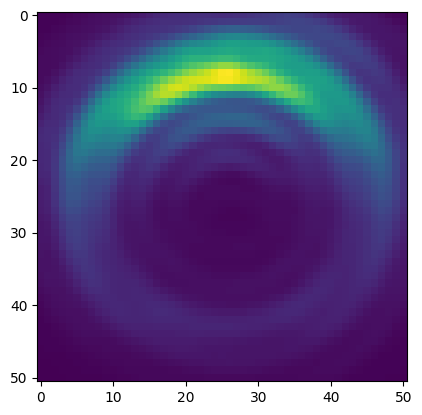

In [31]:
plt.imshow(conv2d)

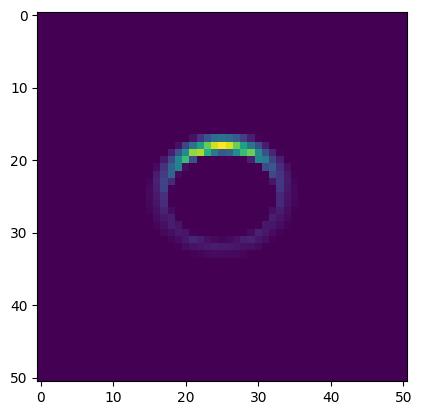

In [32]:
plt.imshow(base_scene._twoD_scene.data)

### Step 5: Simulate the Image on the Detector

So far, we've simulated images of a host star with two companions using Roman-CGI. However, we haven't yet included detector noise! In this step, we'll define a **`corgi.Detector`** object to add detector effects to the simulation.

The `emccd_keywords` dictionary is passed to `instrument.CorgiDetector` to configure the EMCCD detector. It includes the following parameters:

- **em_gain**: Electron multiplication gain. Default is `1000`.
- **full_well_image**: Full well capacity for the image section. Requirement: `50,000`; CBE: `60,000`.
- **full_well_serial**: Full well capacity for the serial register. Requirement: `90,000`; CBE: `100,000`.
- **dark_rate**: Dark current rate in e⁻/pix/s. Requirement: `1.0`; CBE: `0.00042` (0 yrs) / `0.00056` (5 yrs).
- **cic_noise**: Clock-induced charge noise in e⁻/pix/frame. Default: `0.01`.
- **read_noise**: Read noise in e⁻/pix/frame. Requirement: `125`; CBE: `100`.
- **bias**: Bias level in digital numbers (DN). Default: `0`.
- **qe**: Quantum efficiency. Set to `1.0` here, since it's already factored into the photon counts.
- **cr_rate**: Cosmic ray event rate in hits/cm²/s. Use `0` for no cosmic rays, `5` for L2 environment.
- **pixel_pitch**: Pixel pitch in meters. Default: `13e-6`.
- **e_per_dn**: Electrons per data unit after multiplication.
- **numel_gain_register**: Number of elements in the gain register. Default: `604`.
- **nbits**: Number of bits in the ADC (analog-to-digital converter). Default: `14`.
- **use_traps**: Whether to simulate CTI effects using trap models. Default: `False`.
- **date4traps**: Decimal year of observation. Only used if `use_traps=True`. Default: `2028.0`.


In [33]:
### emccd_keywords are the keyword arguments to the internal functions for  emccd_detect,
###  and that everything stays the default settings unless otherwise changed.
### In this example, we'll use the default parameters for the EMCCD detector, except for the EM gain.

gain =100
emccd_keywords ={'em_gain':gain}
detector = instrument.CorgiDetector(emccd_keywords)


The `generate_detector_image` function from the `CorgiDetector` class generates a detector image from the simulated input scene. It takes the following arguments:

- **simulated_scene**: A `corgisim.scene.SimulatedScene` object that contains the noise-free scene from CorgiOptics
- **exptime**: Exposure time in seconds.
- **full_frame** *(bool)*: If `True`, generates a full-frame detector image and places the sub-frame within it.
- **loc_x** *(int)*: Horizontal (x) pixel coordinate of the center where the sub-frame will be inserted. Required if `full_frame=True`.
- **loc_y** *(int)*: Vertical (y) pixel coordinate of the center where the sub-frame will be inserted. Required if `full_frame=True`.


In [34]:

# In real observations, exposures are typically broken into a sequence of short frames (e.g., 100s per frame) to reduce the impact of cosmic ray hits.
# The multi-exposure simulation will be shown below.

exptime = 10
sim_scene = detector.generate_detector_image(sim_scene,exptime)
image_tot_corgi_sub= sim_scene.image_on_detector.data

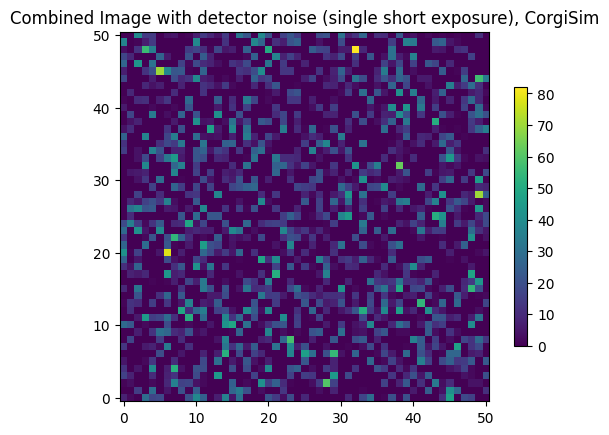

In [35]:
plt.imshow(image_tot_corgi_sub,origin='lower')
plt.title('Combined Image with detector noise (single short exposure), CorgiSim')

co = plt.colorbar(shrink=0.7)

We're not done yet! To complete the simulation, we need to generate a **Level 1 (L1) data product** — a full-frame EMCCD image.

This requires placing the subframe we just simulated onto the full Roman EMCCD frame.  
You can do this by setting the keyword `full_frame=True` in the detector call.

- `loc_x` and `loc_y` specify the center position (in pixels) where the subframe should be placed on the full EMCCD frame.


In [36]:

sim_scene = detector.generate_detector_image(sim_scene,exptime,full_frame=True,loc_x=300, loc_y=300)
image_tot_corgi_full = sim_scene.image_on_detector[1].data

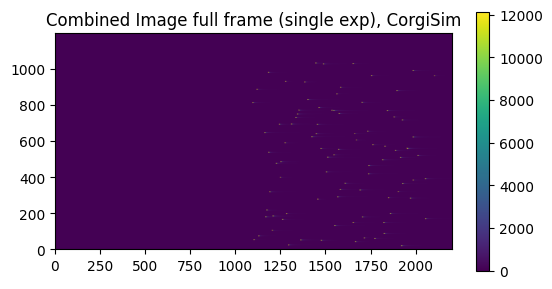

In [37]:
plt.imshow(image_tot_corgi_full,origin='lower')
plt.title('Combined Image full frame (single exp), CorgiSim')

co = plt.colorbar(shrink=0.7)

To aviod the impact of cosmic ray hits, here we simulate multiple exposures and median combine image.

Text(0.5, 1.0, 'Combined Image with detector noise (multi exp: 100s X 100), CorgiSim')

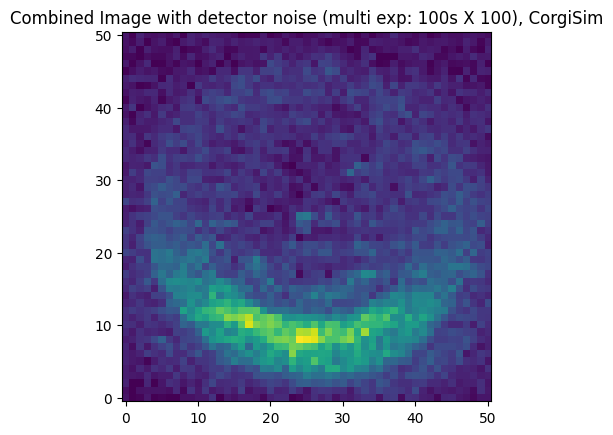

In [38]:
gain =100
emccd_keywords ={'em_gain':gain}
detector = instrument.CorgiDetector(emccd_keywords)


exptime = 100 # intergration time per exposure (s) 
num_exp = 100 # number of exposures per observation
output = np.zeros((num_exp, image_tot_corgi_sub.shape[0], image_tot_corgi_sub.shape[1]))
for t in range(num_exp):
    sim_scene = detector.generate_detector_image(sim_scene,exptime)
    image_tot_corgi_sub= sim_scene.image_on_detector.data
    output[t] = image_tot_corgi_sub


plt.imshow(np.nanmedian(output, axis=0),origin='lower')
plt.title('Combined Image with detector noise (multi exp: {0}s X {1}), CorgiSim'.format(exptime, num_exp))

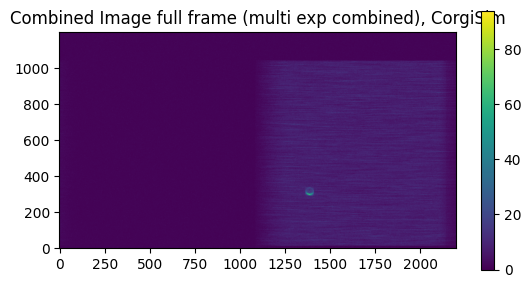

In [39]:
num_exp = 20 # number of exposures per observation
output_full = np.zeros((num_exp, image_tot_corgi_full.shape[0], image_tot_corgi_full.shape[1]))
for t in range(num_exp):
    sim_scene = detector.generate_detector_image(sim_scene,exptime, full_frame=True,loc_x=300, loc_y=300)
    image_tot_corgi_full = sim_scene.image_on_detector[1].data
    output_full[t] = image_tot_corgi_full

plt.imshow(np.nanmedian(output_full, axis=0),origin='lower')
plt.title('Combined Image full frame (multi exp combined), CorgiSim')

co = plt.colorbar(shrink=0.7)

In [40]:
##you can set your output path here
## If outdir is None, the output fits files will be saved in the current working directory.
outdir = None
### save intemediate products
outputs.save_hdu_to_fits(sim_scene.host_star_image, outdir = outdir, filename='host_star_image', write_as_L1=False)

### save final L1 producr
outputs.save_hdu_to_fits(sim_scene.image_on_detector, outdir = outdir, write_as_L1=True)
   

Saved FITS file to: /Users/sxie/Desktop/backup_corgisim/corgisim/examples/host_star_image
Saved FITS file to: /Users/sxie/Desktop/backup_corgisim/corgisim/examples/CGI_0000000000000000000_20250731T1809094_L1_.fits
